In [ ]:
# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2 - Алгоритмы кластеризации


**Срок сдачи:** 17 марта 2017 (РК), 06:00

In [5]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

import matplotlib.pyplot as plt
import mpl_toolkits.basemap as bm

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Реализация алгоритма

In [6]:
data_df = pd.read_csv("places.csv", sep=",", header=0, index_col=0, encoding='utf-8')

In [7]:
x = data_df[['latitude', 'longitude']].values

Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего порядкового номера в списке группы.

28 Крылов Иван

In [5]:
N = 28

In [6]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры - epsilon, min_pts)", 
    u"OPTICS. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[N % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [29]:
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.cluster import KMeans

class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """
    
    def _multivar_norm_pdf(self,X,Mu,Sigma):
        return (
            (2*np.pi)**(-self.D/2)
            * (np.linalg.det(Sigma))**(-1/2)
            * np.exp(
                -1/2
                * (X-Mu).T.dot(np.linalg.inv(Sigma)).dot(X-Mu)
            )
        )
    
    def __init__(self, k):
        """
        Please add necessary algoritm parameters to class constructor.
        """
        self.K = k # number of components/centroids
        return
    
    def _step_E(self,X):
        for n in xrange(self.N):
            for k in xrange(self.K):
                self.gamma[n,k] = (
                    self._pi[k] * self._multivar_norm_pdf(X[n],self.Mu[k],self.Sigma[k])
                    / sum(
                        map(
                            lambda j: self._pi[j] * self._multivar_norm_pdf(X[n],self.Mu[j],self.Sigma[j]),
                            xrange(self.K)
                        )
                    )
                )
        print "gamma", self.gamma
        pass

    
    def _step_M(self,X):
        for k in xrange(self.K):
            self._N[k] = np.sum(self.gamma[:,k])
            self.Mu[k] = 1/self._N[k] * sum(map(
                lambda n: self.gamma[n,k] * X[n],
                xrange(self.N)
            ))
            self.Sigma[k] = 1/self._N[k] * np.sum(
                map(
                    lambda n: self.gamma[n,k] * np.dot(
                        np.matrix(X[n] - self.Mu[k]).T,
                        np.matrix(X[n] - self.Mu[k])
                    ),
                    xrange(self.N)
                ),
                axis=0
            )
            self._pi = self._N / self.N
        print "Mu", self.Mu, "\nSigma", self.Sigma
        pass

    def fit(self, x, y=None):
        """
        Use data matrix x to compute model parameters
        """
        self.N, self.D = x.shape
        
        init = KMeans(n_clusters=self.K).fit(x)
        self.Mu = init.cluster_centers_ # means / centroids
        self.gamma = np.empty((self.N, self.K)) # ownership weight / aposteriori probabilities
        for i in xrange(self.N):
            self.gamma[i,:] = 0
            self.gamma[i,init.labels_[i]] = 1
        
        # to be filled by M-step
        self._N = np.empty(self.K) # N_k
        self._pi = np.empty(self.K) # pi_k = mixing / apriori probabilities
        self.Sigma = np.empty((self.K,self.D,self.D)) # covariances
        self._step_M(x)
        
        for i in xrange(5):
            print "iter", i
            self._step_E(x)
            self._step_M(x)
        
        return self
    
    def predict(self, x):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        ap = np.empty((len(x), self.K))
        labels = np.empty(len(x))
        for n in xrange(len(x)):
            for k in xrange(self.K):
                ap[n,k] = (
                    self._pi[k] * self._multivar_norm_pdf(x[n],self.Mu[k],self.Sigma[k])
                    / sum(
                        map(
                            lambda j: self._pi[j] * self._multivar_norm_pdf(x[n],self.Mu[j],self.Sigma[j]),
                            xrange(self.K)
                        )
                    )
                )
        for point in xrange(0,len(x)):
            print ap[point]
            labels[point] = ap[point,:].argsort()[-1]
            print labels[point]
        
        return labels

    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)

In [31]:
fitted = Clustering(5).fit(x)

Mu [[  93.96324462   93.96324462]
 [ 112.44063074  112.44063074]
 [  90.68518903   90.68518903]
 [ 143.70819733  143.70819733]
 [  86.83544864   86.83544864]] 
Sigma [[[ 1459.30788726  2130.37301664]
  [ 2130.37301664  3113.03063833]]

 [[ 3219.9172705   3163.64116023]
  [ 3163.64116023  3124.61984117]]

 [[  928.13876981  1834.69049767]
  [ 1834.69049767  3635.51674798]]

 [[ 8061.98439438  4816.17414424]
  [ 4816.17414424  3054.30439602]]

 [[ 1655.18585731  1879.68184331]
  [ 1879.68184331  2140.0492774 ]]]
iter 0
gamma [[  1.00000000e+00   1.00938423e-11   2.05810035e-14   3.99832089e-11
    1.68565081e-16]
 [  2.16847979e-35   1.03692519e-01   6.33621354e-56   4.98232574e-07
    8.96306983e-01]
 [  3.34182579e-28   1.50887687e-26   1.00000000e+00   1.70971032e-13
    6.27280912e-55]
 ..., 
 [  1.00000000e+00   6.03504237e-12   8.55664025e-14   3.83059881e-11
    4.55401092e-17]
 [  1.00000000e+00   2.18085447e-12   2.86132058e-12   4.43125658e-11
    2.27028800e-18]
 [  5.80890230

In [32]:
labels = fitted.predict(x)

[  9.99966741e-01   2.08424459e-75   5.07601570e-15   1.08916863e-11
   3.32594236e-05]
0.0
[  0.00000000e+00   2.24831205e-07   2.01608545e-55   1.80377950e-06
   9.99997971e-01]
4.0
[  0.00000000e+000   1.66372021e-173   1.00000000e+000   1.91269979e-013
   1.59637496e-012]
2.0
[  0.00000000e+00   9.91615118e-01   5.37996024e-82   3.80043165e-04
   8.00483918e-03]
1.0
[  0.00000000e+000   4.19211562e-095   5.53562993e-195   1.00000000e+000
   4.96987415e-021]
3.0
[  0.00000000e+000   4.25206055e-095   5.62182889e-195   1.00000000e+000
   4.98282572e-021]
3.0
[  0.00000000e+00   9.92012339e-01   7.13114465e-82   3.39050672e-04
   7.64861059e-03]
1.0
[  0.00000000e+00   9.92178931e-01   7.51673459e-82   3.23383866e-04
   7.49768528e-03]
1.0
[  0.00000000e+00   9.92087496e-01   7.12306745e-82   3.32282802e-04
   7.58022123e-03]
1.0
[  9.99991348e-01   2.30203250e-76   1.94476402e-15   2.93877694e-12
   8.65169899e-06]
0.0
[  0.00000000e+000   3.88266023e-095   6.14384443e-195   1.000000

In [39]:
print labels

[ 0.  4.  2. ...,  0.  4.  4.]


Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

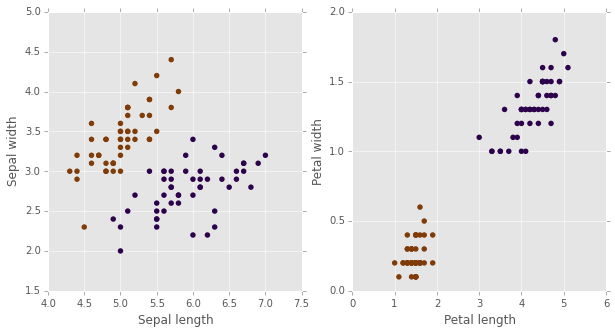

In [36]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [40]:
pred_iris = Clustering(2).fit_predict(x_iris)
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

Mu [[ 10.132  10.132  10.132  10.132]
 [ 14.292  14.292  14.292  14.292]] 
Sigma [[[  26.39764    34.514256   44.447984   50.696224]
  [  34.514256   45.220072   58.2084     66.39924 ]
  [  44.447984   58.2084     75.163728   85.714768]
  [  50.696224   66.39924    85.714768   97.783808]]

 [[  70.08384    96.361312   84.006632  108.39856 ]
  [  96.361312  132.852984  115.669704  149.434632]
  [  84.006632  115.669704  100.857424  130.146552]
  [ 108.39856   149.434632  130.146552  168.15548 ]]]
iter 0
gamma [[  1.00000000e+000   7.63705002e-048]
 [  1.00000000e+000   1.51121819e-033]
 [  1.00000000e+000   3.53143737e-039]
 [  1.00000000e+000   3.53625207e-032]
 [  1.00000000e+000   6.53294866e-050]
 [  1.00000000e+000   4.79550383e-052]
 [  1.00000000e+000   6.30794748e-040]
 [  1.00000000e+000   2.89946499e-042]
 [  1.00000000e+000   2.09273449e-028]
 [  1.00000000e+000   1.36562497e-034]
 [  1.00000000e+000   3.10935583e-053]
 [  1.00000000e+000   1.42880007e-038]
 [  1.00000000e+00

Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

In [10]:
def quality(x, y):
    """
    Inertia
    """
    return NaN

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

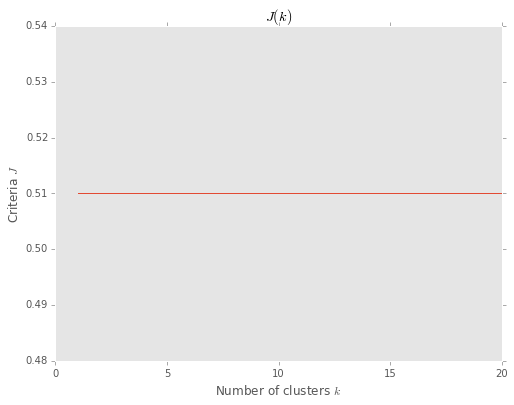

In [11]:
ks = range(1, 21)
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    cls = Clustering()
    y = cls.fit_predict(x)
    criteria[i] = quality(x, y)
    
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()

Далее необходимо кластеризовать данные, используя выбранное количество кластеров, и визуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время. 

In [41]:
k = 5
cls = Clustering(k)
y = cls.fit_predict(x)

Mu [[  93.96324462   93.96324462]
 [ 112.44063074  112.44063074]
 [ 143.70819733  143.70819733]
 [  90.68518903   90.68518903]
 [  86.83544864   86.83544864]] 
Sigma [[[ 1459.30788726  2130.37301664]
  [ 2130.37301664  3113.03063833]]

 [[ 3219.9172705   3163.64116023]
  [ 3163.64116023  3124.61984117]]

 [[ 8061.98439438  4816.17414424]
  [ 4816.17414424  3054.30439602]]

 [[  928.13876981  1834.69049767]
  [ 1834.69049767  3635.51674798]]

 [[ 1655.18585731  1879.68184331]
  [ 1879.68184331  2140.0492774 ]]]
iter 0
gamma [[  1.00000000e+00   1.00938423e-11   3.99832089e-11   2.05810035e-14
    1.68565081e-16]
 [  2.16847979e-35   1.03692519e-01   4.98232574e-07   6.33621354e-56
    8.96306983e-01]
 [  3.34182579e-28   1.50887687e-26   1.70971032e-13   1.00000000e+00
    6.27280912e-55]
 ..., 
 [  1.00000000e+00   6.03504237e-12   3.83059881e-11   8.55664025e-14
    4.55401092e-17]
 [  1.00000000e+00   2.18085447e-12   4.43125658e-11   2.86132058e-12
    2.27028800e-18]
 [  5.80890230

Визуализируем кластеризацию на карте

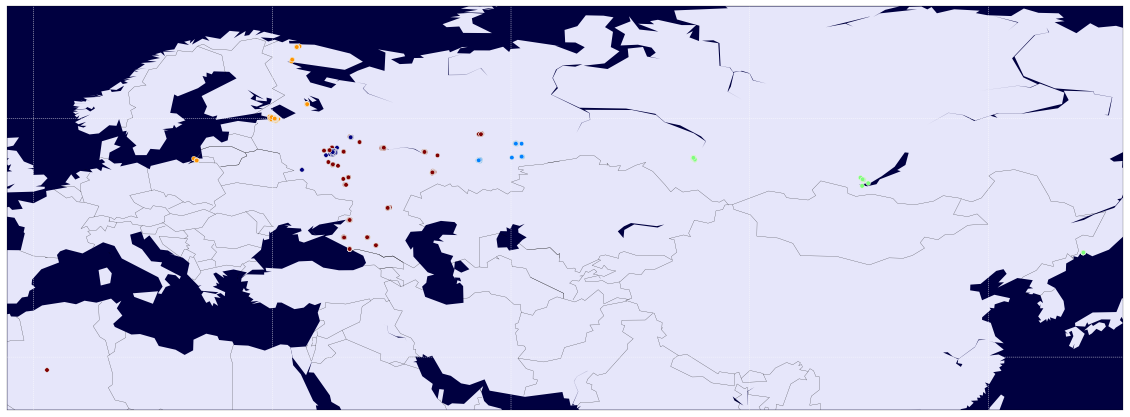

In [42]:
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=min(x[:, 0]) - 5, urcrnrlat=max(x[:, 0]) + 5, llcrnrlon=min(x[:, 1]) - 5, urcrnrlon=max(x[:, 1]) + 5, resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

m.scatter(x[:, 1], x[:,0], c=y, zorder=10)
    
pl.show()

Визуализируйте интересные участки (может быть это Москва) в приближенном виде. Постройте 3 (или более, в зависимости от данных, что вам самим бы хотелось увидеть ближе) увеличенных изображений карты с кластеризацией.

In [10]:
import folium as fl
# your code with maps here

Какой вывод можно сделать о качестве кластеризации?

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.